In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
#from feature_engineering import add_retning
from sklearn.model_selection import train_test_split
import pandas as pd
import sys
import lightgbm as lgb
import sklearn as skl
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
import pandas as pd
import sys
from functools import partial
import optuna

sys.path.append('../data')

from display_data import import_data

In [52]:
def add_parks_and_schools(df):
    """with parks we are going to add all as radius to different parks, will also do this with schools"""
    parks = pd.read_csv('parks_cordinates.csv')
    schools = pd.read_csv('school_cordinates.csv')
    parks = convert_from_coordinates_to_lat_long(parks)
    schools = convert_from_coordinates_to_lat_long(schools)

    total = remove_duplicates(parks,schools)

    for i, cordinate in enumerate(total):
        df['radius'+ str(i)] = np.sqrt((cordinate[0]-df['latitude'])**2 + (cordinate[1]-df['longitude'])**2)


    return df



def remove_duplicates(parks,schools):
    """we want to remove places which is really close"""
    schools = schools.drop(schools[schools['school']=='????????????'].index)
    schools = schools.drop(schools[schools['school']=='Electronics_and_maths'].index)
    schools = schools.drop(schools[schools['school']=='MSU'].index)
    parks = parks.drop(parks[parks['park']=='vorobyovy_gory'].index)
    parks = parks.drop(parks[parks['park']=='bittsevskiy_park'].index)

    return np.concatenate((schools[['latitude','longitude']].to_numpy(),parks[['latitude','longitude']].to_numpy()))

def closest_park(df):
    parks = pd.read_csv('parks_cordinates.csv')
    parks = convert_from_coordinates_to_lat_long(parks)

    df = find_closest(df,parks,'park')

    return df

def closest_school(df):
    schools = pd.read_csv('school_cordinates.csv')
    schools = convert_from_coordinates_to_lat_long(schools)

    df = find_closest(df,schools,'school')

    return df

def closest_attraction(df):
    attractions = pd.read_csv('attractions_cordinates.csv')
    attractions = convert_from_coordinates_to_lat_long(attractions)

    df = find_closest(df,attractions,'atraction')

    return df

    return df

def closest_school(df):
    schools = pd.read_csv('school_cordinates.csv')
    schools = convert_from_coordinates_to_lat_long(schools)

    df = find_closest(df,schools,'school')

    return df

def closest_attraction(df):
    attractions = pd.read_csv('attractions_cordinates.csv')
    attractions = convert_from_coordinates_to_lat_long(attractions)

    df = find_closest(df,attractions,'atraction')

    return df

def closest_attraction(df):
    attractions = pd.read_csv('attractions_cordinates.csv')
    attractions = convert_from_coordinates_to_lat_long(attractions)

    df = find_closest(df,attractions,'atraction')

    return df

def closest_train(df):
    trains = pd.read_csv('train_cordinates.csv')
    trains = convert_from_coordinates_to_lat_long(trains)

    df = find_closest(df,trains,'train_station')

    return df

def closest_metro(df):
    metroes = pd.read_csv('metro_cordinates.csv')
    metroes = convert_from_coordinates_to_lat_long(metroes,metro=True)

    df = find_closest(df, metroes,'metro_station')

    return df

def find_closest(df,df_with_coordinates,text):
    """finds closets location for each location in df to all the locations in df_with_coordinates"""
    df[['closest_' + text,'distance_' + text]] = df.apply(closest,args=(df_with_coordinates,text),axis=1)
    df['closest_'+text] = df['closest_'+text].astype(float)

    return df

def closest(df, list_of_coordinates_and_category,text):
    if df.id%1000==0:
        print(df.id)
    """finds the closets coordinate in list of coordinates and the given coordinate"""
    point= df[['latitude','longitude']].to_numpy()
    list_of_coordinates_and_category['distances'] = list_of_coordinates_and_category.apply(calculate_distance,args=(point[0],point[1]),axis=1)
    shortest_row = list_of_coordinates_and_category['distances'].idxmin()
    return list_of_coordinates_and_category.iloc[shortest_row][[text,'distances']]
    #calculate_distance(coordinate, list_of_coordinates_and_category[['longitude','latitude']])

def calculate_distance(df,pointlat,pointlong):
    """calculates the distance between two points"""
    distance = np.sqrt((pointlat-df['latitude'])**2 + (pointlong-df['longitude'])**2)
    return distance

def convert_from_coordinates_to_lat_long(df,metro=False):
    if metro:
        df[['latitude','longitude']] = df['coordinates'].str.split(" ",1, expand=True)
        df[['latitude','longitude']] = df[['latitude','longitude']].astype(float)
    else:
        df[['latitude','longitude']] = df['coordinates'].str.split(',',1, expand=True)
        df[['latitude','longitude']] = df[['latitude','longitude']].astype(float)

    return df

def fix_missing_value(df):
    #layout, set everythin to 1
    df['layout'].fillna(int(1.0),inplace=True)



    #found correleation between number of stories and balconies,loggias
    df.loc[(df['stories'] < 7.0)&df['loggias'].isna(),'loggias'] = 0
    df.loc[(df['stories'] < 7.0)&df['balconies'].isna(),'balconies'] = 1

    df.loc[((df['stories'] > 12) & (df['stories'] < 16))|((df['stories'] > 17) & (df['stories'] < 24))&(df['loggias'].isna()),'loggias'] = 1
    df.loc[((df['stories'] > 12) & (df['stories'] < 16))|((df['stories'] > 17) & (df['stories'] < 24))&(df['loggias'].isna()),'balconies'] = 0


    #use the correleation between balconies and loggias to replace nans,
    df.loc[(df['loggias'] == 0.0 )& df['balconies'].isna(),'balconies'] = 1
    df.loc[(df['balconies'] == 0.0 )& df['loggias'].isna(),'loggias'] = 1
    df.loc[(df['loggias'] > 0.0 )& df['balconies'].isna(),'balconies'] = 0
    df.loc[(df['balconies'] > 0.0 )& df['loggias'].isna(),'loggias'] = 0

    #use correlation between material and ceiling groups
    ceiling_under_2 = len(df[((df['material'] == 4)|(df['material'] == 3)) & df['ceiling'].isna()])
    sample = df[df['ceiling'] < 2.6]['ceiling'].sample(n=ceiling_under_2,replace=True).to_numpy()
    df.loc[((df['material'] == 4)|(df['material'] == 3)) & (df['ceiling'].isna()),'ceiling'] = sample
    #use corelation between condition and ceiling groups
    ceiling_under_2 = len(df[(df['condition'] == 1) & df['ceiling'].isna()])
    sample = df[df['ceiling'] < 2.6]['ceiling'].sample(n=ceiling_under_2,replace=True).to_numpy()
    df.loc[(df['condition'] == 1) & df['ceiling'].isna(),'ceiling'] = sample


    #use correleation betwwen ceiling and area
    ceiling_over_3 = len(df[(df['area_total'] > 104)&(df['ceiling'].isna())])
    sample = df[df['ceiling'] > 3.0]['ceiling'].sample(n=ceiling_over_3,replace=True).to_numpy()
    df.loc[(df['area_total'] > 104)&(df['ceiling'].isna() ),'ceiling'] = sample

    ceiling_over_3 = len(df[(df['area_total'] > 75)&(df['ceiling'].isna())])
    sample = df[df['ceiling'] > 2.95]['ceiling'].sample(n=ceiling_over_3,replace=True).to_numpy()
    df.loc[(df['area_total'] > 75)&(df['ceiling'].isna() ),'ceiling'] = sample

    ceiling_under_2 = len(df[(df['area_total'] < 55)&(df['ceiling'].isna())])
    sample = df[df['ceiling'] < 2.8]['ceiling'].sample(n=ceiling_under_2,replace=True).to_numpy()
    df.loc[(df['area_total'] < 55)&(df['ceiling'].isna() ),'ceiling'] = sample

    #seller
    #use correleation between seller and new
    df.loc[(df['new'] == 1 )& df['seller'].isna(),'seller'] = 3

    #use correleation between seller and constructed
    df.loc[(df['constructed'] > 2018)& df['seller'].isna(),'seller'] = 3
    df.loc[(df['constructed'] < 1990)& df['seller'].isna(),'seller'] = 1

    #use correleation between seller and stories
    df.loc[(df['stories'] > 17)& df['seller'].isna(),'seller'] = 3
    df.loc[(df['stories'] < 9)& df['seller'].isna(),'seller'] = 1

    #use correleation between seller and district
    df.loc[((df['district'] == 3)|(df['district']==6))& df['seller'].isna(),'seller'] = 1
    df.loc[((df['district'] == 11)|(df['district']==2))& df['seller'].isna(),'seller'] = 3

    #conditon
    #use correleation between condition and new
    df.loc[(df['new'] == 1)& df['condition'].isna(),'condition'] = 0

    #use correleation between condition and constructed year
    df.loc[(df['constructed'] >= 2017)& df['condition'].isna(),'condition'] = 0
    df.loc[(df['constructed'] <= 1989)& df['condition'].isna(),'condition'] = 1

    #material
    #use correlation between material and district
    df.loc[(df['district'] == 3)& df['material'].isna(),'material'] = 3

    #use correleation between material and constructed year
    df.loc[((df['constructed'] > 1970)& (df['constructed'] <= 1989))&df['material'].isna(),'material'] = 3
    df.loc[(df['constructed'] <= 1970)&df['material'].isna(),'material'] = 0

    #use correleation between stories and material
    df.loc[(df['stories'] < 7)& df['material'].isna(),'material'] = 0
    df.loc[((df['stories'] > 7)&(df['stories'] < 9))& df['material'].isna(),'material'] = 3

    #use correleation between conditon and material
    df.loc[(df['condition'] == 3)& df['material'].isna(),'material'] = 3
    df.loc[(df['condition'] == 0)& df['material'].isna(),'material'] = 2

    #use correleation between parking and material
    df.loc[((df['parking'] == 3)|(df['parking'] == 2))& df['material'].isna(),'material'] = 2

    #user correlation between area and material
    df.loc[(df['area_total'] > 104)& df['material'].isna(),'material'] = 2

    #parking
    #use coreletion between parking and material
    df.loc[((df['material'] == 0)|(df['material'] == 3))& df['parking'].isna(),'parking'] = 1

    #use correleation between stories and parking
    df.loc[((df['stories'] > 30))& df['parking'].isna(),'parking'] = 0
    df.loc[((df['stories'] > 7)&(df['stories'] < 9))& df['parking'].isna(),'parking'] = 1

    #use correleation between radius and parking
    df.loc[(df['radius'] < 0.0547)& df['parking'].isna(),'parking'] = 0
    df.loc[(df['radius'] > 0.251)& df['parking'].isna(),'parking'] = 1

    #windows_court and windows_street
    #windows_street and balconies
    df.loc[(df['balconies'] == 2)& df['windows_street'].isna(),'windows_street'] = 1

    #windows street and area
    df.loc[(df['area_total'] > 106)& df['windows_street'].isna(),'windows_street'] = 1
    df.loc[(df['area_total'] < 47)& df['windows_street'].isna(),'windows_street'] = 0

    #windwos_street and stories
    df.loc[(df['stories'] > 40)& df['windows_street'].isna(),'windows_street'] = 1
    df.loc[(df['stories'] < 9)& df['windows_street'].isna(),'windows_street'] = 0

    #windows_street and windows_court
    df.loc[(df['windows_street'] == 0)& df['windows_court'].isna(),'windows_court'] = 1

    df.loc[((df['windows_street'] == 1)& (df['area_total'] > 75)) & df['windows_court'].isna(),'windows_court'] = 1
    df.loc[((df['windows_street'] == 1)& (df['area_total'] < 47)) & df['windows_court'].isna(),'windows_court'] = 0

    #balconies
    #balconies and stories
    df.loc[((df['stories'] >= 12)& (df['area_total'] <= 16)) & df['balconies'].isna(),'balconies'] = 0
    df.loc[(df['stories'] < 7) & df['balconies'].isna(),'balconies'] = 1
    df.loc[((df['stories'] > 17)& (df['area_total'] <= 24)) & df['balconies'].isna(),'balconies'] = 0

    #matrial and balconies
    df.loc[(df['material'] == 0) & df['balconies'].isna(),'balconies'] = 1
    df.loc[(df['material'] == 2) & df['balconies'].isna(),'balconies'] = 0

    #balconies and constructed
    df.loc[(df['constructed'] < 1970) & df['balconies'].isna(),'balconies'] = 1
    df.loc[(df['constructed'] > 2018) & df['balconies'].isna(),'balconies'] = 0

    #loggias
    #loggias and balconies
    df.loc[(df['balconies'] == 0) & df['loggias'].isna(),'loggias'] = 1
    df.loc[(df['balconies'] > 0) & df['loggias'].isna(),'loggias'] = 0

    #loggias and stories
    df.loc[(df['stories'] < 7) & df['loggias'].isna(),'loggias'] = 0
    df.loc[((df['stories'] >= 17)& (df['area_total'] <= 24)) & df['loggias'].isna(),'loggias'] = 1

    #bathrooms shared, bathroomes private

    #loggias and blaconies



    return df

def add_radius(df):
    #adds radius column to dataframe
    df['radius'] = np.sqrt((df['latitude']-55.75)**2 + (df['longitude']-37.55)**2)
    return df

def group_by_feature_and_price(df, feature, data_train = pd.DataFrame()):
    #makes a new column with the mean price for each group to all rows
    if data_train.empty:
        grouped = df.groupby([feature])

        mean_price = grouped['price'].mean()

        df_merged = pd.merge(df,mean_price, on=feature, how='left')

        column_name = str(feature + '_price')

        df[column_name] = df_merged['price_y']
    else:
        grouped = data_train.groupby([feature])

        mean_price = grouped['price'].mean()

        df_merged = pd.merge(df,mean_price, on=feature, how='left')

        column_name = str(feature + '_price')

        df[column_name] = df_merged['price']
    return df

def one_hot_encode(df, column_to_encode):
    """one hots encode for one singel column"""
    encoded_df = pd.get_dummies(df[[column_to_encode]].astype(str))
    df = pd.concat([df,encoded_df],axis=1)
    return df

def one_hot_encode_multiple(df, list_of_columns):
    """takes in multiple columns and runs one hot encode for each column"""
    for column_to_encode in list_of_columns:
        #print(column_to_encode)
        df = one_hot_encode(df, column_to_encode)
    return df

def add_direction(df):
    """adds direction to dataframe, can be one of eight categories (N,S,W,E)"""
    #straight up (north)
    normal_vector = np.array([0,1])
    #normal_vector = np.tile(normal_vector,(df.shape[0],1))
    #normal_vector = normal_vector.reshape((2,-df.shape[0]))
    temp = pd.DataFrame()
    temp['latitude'] = df['latitude']-55.75
    temp['longitude'] = df['longitude']-37.56


    apartment_vector = temp[['latitude','longitude']].to_numpy()


    #print(np.shape(apartment_vector), np.shape(normal_vector))
    angles = []
    for vector in apartment_vector:
        if vector[0] < 0:
            temp_angle = -angle_between(vector,normal_vector)
        else:
            temp_angle = angle_between(vector,normal_vector)
        angles.append(temp_angle)

    angles = [element * 10 for element in angles]


    angles_series = pd.Series(np.array(angles))
    #angles_series.plot.hist()

    df['angle'] = angles_series
    max = df.angle.max()
    min = df.angle.min()
    bins = [min,min*7/8,min*5/8,min*3/8,min/8,max/8,max*3/8,max*5/8,max*7/8,max]
    rounded_bins = [element for element in bins]
    #print(rounded_bins)
    direction = pd.cut(df.angle, bins= rounded_bins,labels=['S','SW','W','NW','N','NE','E','SE','S'],ordered=False)
    df['direction'] = direction
    return df

def unit_vector(vector):
    """returns the unit vector if the vector"""
    return vector/np.linalg.norm(vector)

def angle_between(v1,v2):
    """returns angle between two vectors in radian"""
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u,v2_u),-1,1))

def fix_geo_data(data_test):
    """should just be called on test data"""
    #fix all radius issues
    data_test._set_value(23,'longitude',37.473761)
    data_test._set_value(23,'latitude',55.560891)
    data_test._set_value(90,'longitude',37.473761)
    data_test._set_value(90,'latitude',55.560891)

    data_test._set_value(2511,'longitude',37.478055)
    data_test._set_value(2511,'latitude',55.544046)
    data_test._set_value(5090,'longitude',37.478055)
    data_test._set_value(5090,'latitude',55.544046)
    data_test._set_value(6959,'longitude',37.478055)
    data_test._set_value(6959,'latitude',55.544046)
    data_test._set_value(8596,'longitude',37.478055)
    data_test._set_value(8596,'latitude',55.544046)

    data_test._set_value(4719,'longitude',37.385493)
    data_test._set_value(4719,'latitude',55.853117)

    data_test._set_value(9547,'longitude',37.384711)
    data_test._set_value(9547,'latitude',55.853511)

    data_test._set_value(2529,'longitude',37.464994)
    data_test._set_value(2529,'latitude',55.627666)

    data_test = add_radius(data_test)

    return data_test

def drop_n_largest(data_train):
    """drops 4 largest values, should only be called on training set"""
    #drop 4 largest from training data, maybe not samrt, but we will see
    data_train.drop([3217,21414,15840,13938])
    return data_train

def clean_data(all_data):
    """cleans the data with all the knowledge we have so far"""


    #fix ceiling issues
    all_data.loc[all_data['ceiling'] > 50,'ceiling']*=0.01
    all_data.loc[all_data['ceiling'] > 25, 'ceiling']*=0.1
    all_data.loc[all_data['ceiling'] < 0.5,'ceiling'] = float('NaN')
    """"
    #fix area_kitchen and area_living issues
    all_data['living'] = all_data.area_living/all_data.area_total
    all_data['kitchen'] = all_data.area_total/all_data.area_kitchen

    all_data.loc[all_data['living'] > 1,'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[all_data['living'] > 1,'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100

    all_data.loc[all_data.area_living/all_data.area_total > 1, 'area_living'] = float('NaN')

    all_data['living'] = all_data.area_living/all_data.area_total
    all_data['kitchen'] = all_data.area_kitchen/all_data.area_total

    all_data['sum_area'] = all_data.area_living + all_data.area_kitchen
    all_data.loc[all_data['sum_area'] == 100, 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[all_data['sum_area'] == 100, 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100

    #this fixed some few rows.
    #when printing we see some other very clear "precentage situations, fixing these
    all_data.loc[all_data['sum_area'] == 38.5, 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[all_data['sum_area'] == 38.5, 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[all_data['sum_area'] == 52.7, 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[all_data['sum_area'] == 52.7, 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[all_data['sum_area'] == 71.6, 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[all_data['sum_area'] == 71.6, 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 20), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 20), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 15), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 15), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 10), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 10), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 30), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 30), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 10), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 10), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 15), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 15), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 20), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 20), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 25), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 25), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 30), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 30), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 50), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 50), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 60) & (all_data['area_total'] > 120), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 60) & (all_data['area_total'] > 120), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] < 70) & (all_data['area_total'] > 120)&(all_data['rooms'] < 3), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] < 70) & (all_data['area_total'] > 120)&(all_data['rooms'] < 3), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    """
    return all_data

def add_high_up(df):
    """add exponetital function to determine how high up a building is"""
    high_up = df.floor/df.stories
    high_up_exp = np.exp(high_up) - 1
    euler = np.exp(1)

    df['high_up'] = high_up_exp
    df['high_up'].where(df['high_up'] > euler, euler)


    return df

def log_radius(df):
    df['radius'] = np.log(df['radius'])
    return df

def cluster_geo_data(df,df_test):
    
    from sklearn.cluster import KMeans
    k_means = KMeans(n_clusters = 100, max_iter = 1000, init='k-means++')

    lat_long_pairs = df[['latitude','longitude']]
    lat_long_pairs_test = df_test[['latitude','longitude']]
    target_data = np.log(df.price)/np.log(15)

    k_means.fit(lat_long_pairs,sample_weight = target_data)
    df['cluster_number'] = k_means.predict(lat_long_pairs)
    df_test['cluster_number'] = k_means.predict(lat_long_pairs_test)

    return df, df_test

def fix_radius(data_test):
    """should just be called on test data"""
    #fix all radius issues
    data_test._set_value(23,'radius',0.203899)
    data_test._set_value(90,'radius',0.203899)
    data_test._set_value(2511,'radius',0.218159)
    data_test._set_value(5090,'radius',0.218159)
    data_test._set_value(6959,'radius',0.218159)
    data_test._set_value(8596,'radius',0.218159)
    data_test._set_value(4719, 'radius',0.19580)
    data_test._set_value(9547, 'radius',0.19520)
    data_test._set_value(2529, 'radius', np.sqrt((37.464994-37.55)**2+(55.627666-55.75)**2))

    return data_test    

def rf_data_prep(data_rf,data_test_rf):
    Y = data_rf.price
    radius = True
    # Add radius
    if(radius):
        data_rf = add_radius(data_rf)
        data_test = add_radius(data_test_rf)
        #coordinates = ['latitude', 'longitude']
        #data = data.drop(columns = coordinates)
        #data_test = data_test.drop(columns = coordinates)


    data_rf = data_rf.drop(columns = ['area_living', 'area_kitchen'])
    data_test_rf = data_test_rf.drop(columns = ['area_living', 'area_kitchen'])

    categorical_data = ['seller','layout', 'windows_court', 'windows_street', 'condition', 'building_id','new','district','street',
                        'address', 'material', 'elevator_without', 'elevator_passenger', 'elevator_service', 'parking','garbage_chute', 'heating']
    cleaning = True

    if(cleaning):
        data_test_rf = fix_radius(data_test_rf)
        data_rf = clean_data(data_rf)
        data_test_rf = clean_data(data_test_rf)

    data_columns_rf = list(data_rf.columns)
    numerical_data = list(set(data_columns_rf)-set(categorical_data))
    print(numerical_data)
    for column in numerical_data:
        mean = data_rf[column].mean()
        data_rf[column] = data_rf[column].replace(np.NaN, mean)
        if column != 'price':
            mean_test = data_test_rf[column].mean()
            data_test_rf[column] = data_test_rf[column].replace(np.NAN,mean)

    #Features
    radius = True
    district_mean_price = False #her er det nan
    ohe = True
    direction = True
    high_up = True
    #add high up


    if(high_up):
        data_rf = add_high_up(data_rf)
        data_test_rf = add_high_up(data_test_rf)

    if(district_mean_price):
        data_rf = group_by_feature_and_price(data_rf,'district')
        data_test_rf = group_by_feature_and_price(data_test_rf,'district',data_train=data_rf)
        data_rf = data_rf.drop(columns=['price', 'id'])


    if(direction):
        data_rf = add_direction(data_rf)
        data_test_rf = add_direction(data_test_rf)
        data_rf = one_hot_encode(data_rf, 'direction')
        data_test_rf = one_hot_encode(data_test_rf, 'direction')
        data_rf = data_rf.drop(columns = 'direction')
        data_test_rf = data_test_rf.drop(columns = 'direction')


    #One hot encode data
    if(ohe):
        encode_categorical_data_rf = ['seller','layout', 'windows_court', 'windows_street', 'condition','new','district',
                        'material', 'elevator_without', 'elevator_passenger', 'elevator_service', 'parking','garbage_chute', 'heating']
        data_rf = one_hot_encode_multiple(data_rf,encode_categorical_data_rf)
        data_test_rf = one_hot_encode_multiple(data_test_rf,encode_categorical_data_rf)
    #####HER MÅ DET FIKSES 
    # skal man logtransformere`?
    #data_rf['price'] = np.log(data_rf['price'])/np.log(15)
    ### TROR IKKE MAN TRENGER SCALE
    #scaler = MinMaxScaler() # mapper alt til mellom 0 og 1, default
    #data_rf[numerical_data] = scaler.fit_transform(data_rf[numerical_data])
    #Y = scale(Y) ##FIKS her
    #Y = data_rf['price']
    data_rf = data_rf.drop(columns=['price', 'id'])

    #Drop cat_data
    data_rf = data_rf.drop(columns = categorical_data) # har one-hot encoda lengre oppe
    data_test_rf = data_test_rf.drop(columns=['id'])
    data_test_rf = data_test_rf.drop(columns = categorical_data) #må huske testdataen
    
    ## Rot under her

    nan_values = data_rf.isna().any()
    nan_columns = nan_values.any()


    columns_with_nan = data_rf.columns[nan_columns].tolist()
    #print(nan_values)
    #print(columns_with_nan)
    for column in data_rf.columns:
        if data_rf[column].isna().any():
            print(column)

    print(Y)
    if (Y.values < 0).any():
        print('Gunnar')
    return data_rf, data_test_rf


In [53]:
#We dont want our model to care about the id of the house or the seller
data, data_test = import_data()
data_light, data_test_light = import_data()

Y = data.price
test_id = data_test.id

radius = True
# Add radius
if(radius):
    data = add_radius(data)
    data_test = add_radius(data_test)
    #coordinates = ['latitude', 'longitude']
    #data = data.drop(columns = coordinates)
    #data_test = data_test.drop(columns = coordinates)
    #data_light = add_radius(data_light)
    #data_test_light = add_radius(data_test_light)

fix_missing = False
if fix_missing:
    data = fix_missing_value(data)
    data_test = fix_missing_value(data_test)
    #data_light = fix_missing_value(data_light)
    #data_test_light = fix_missing_value(data_test_light)

cleaning = True
if(cleaning):
    data_test = fix_geo_data(data_test)
    data = clean_data(data)
    data_test = clean_data(data_test)
    #data_test_light = fix_geo_data(data_test_light)
    #data_light = clean_data(data_light)
    #data_test_light = clean_data(data_test_light)

closest_school = False
closest_park = False
closest_metro = False
closest_attraction = False
closest_train = False
"""when setting one of these to True, you need to make sure to add the different important things."""

if (closest_school):
    data = closest_school(data)
    data_test = closest_school(data_test)

if (closest_park):
    data = closest_park(data)
    data_test = closest_park(data_test)

if (closest_train):
    data = closest_train(data)
    data_test = closest_train(data_test)

if (closest_metro):
    data = closest_metro(data)
    data_test = closest_metro(data_test)

if (closest_attraction):
    data = closest_attraction(data)
    data_test = closest_attraction(data_test)


data_test_light = data_test
data_light = data
categorical_data = ['seller','layout', 'windows_court', 'windows_street', 'condition', 'building_id','new','district','street',
                    'address', 'material', 'elevator_without', 'elevator_passenger', 'elevator_service', 'parking','garbage_chute', 'heating','cluster_number','layout']

data_columns = list(data.columns)
numerical_data = list(set(data_columns)-set(categorical_data))
print(numerical_data)
for column in numerical_data:
    mean = data[column].mean()
    data[column] = data[column].replace(np.NaN, mean)
    if column != 'price':
        mean_test = data_test[column].mean()
        data_test[column] = data_test[column].replace(np.NAN,mean)

#Features
radius = True
district_mean_price = True
ohe = True
direction = True
high_up = True
#add high up
log_r = False
cluster = True



if(high_up):
    data = add_high_up(data)
    data_test = add_high_up(data_test)
    data_light = add_high_up(data_light)
    data_test_light = add_high_up(data_test_light)

data = data.drop(columns = ['area_living', 'area_kitchen'])
data_test = data_test.drop(columns = ['area_living', 'area_kitchen'])

if(cluster):
    data,data_test = cluster_geo_data(data,data_test)
    data_light,data_test_light = cluster_geo_data(data_light,data_test_light)

if(district_mean_price):
    data = group_by_feature_and_price(data,'district')
    data_test = group_by_feature_and_price(data_test,'district',data_train=data)
    data = data.drop(columns=['price', 'id'])

#cat data should not be one hot encoded, and it doest accept nan values
data_cat,data_cat_test = data,data_test
data_cat = data_cat.fillna('None')
data_cat_test = data_cat_test.fillna('None')

if(direction):
    data = add_direction(data)
    data_test = add_direction(data_test)
    data = one_hot_encode(data, 'direction')
    data_test = one_hot_encode(data_test, 'direction')
    data = data.drop(columns = 'direction')
    data_test = data_test.drop(columns = 'direction')

    data_light = add_direction(data_light)
    data_test_light = add_direction(data_test_light)

    data_cat = add_direction(data_cat)
    data_cat_test = add_direction(data_cat_test)


#One hot encode data
if(ohe):
    encode_categorical_data = ['seller','layout', 'windows_court', 'windows_street', 'condition','new','district',
                     'material', 'elevator_without', 'elevator_passenger', 'elevator_service', 'parking','garbage_chute', 'heating','cluster_number']
    data = one_hot_encode_multiple(data,encode_categorical_data)
    data_test = one_hot_encode_multiple(data_test,encode_categorical_data)

if(log_r):
    data = log_radius(data)
    data_test = log_radius(data_test)
    data_light = log_radius(data_light)
    data_test_light = log_radius(data_test_light)




#Drop cat_data
data = data.drop(columns = categorical_data)
data = data.drop(columns = ['latitude','longitude'])
data_test = data_test.drop(columns=['id','latitude','longitude'])
data_test = data_test.drop(columns = categorical_data)
print(data.info())

focus_light = ['cluster_number','seller','material','district','condition','parking','new','direction','constructed','elevator_without','garbage_chute','loggias','layout','balconies','floor','high_up','rooms','area_total','radius','ceiling','angle']
light_features = (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14)
focus_cat = ['elevator_passenger', 'elevator_service','windows_court', 'windows_street','cluster_number','seller','material','district','condition','parking','new','constructed','elevator_without','garbage_chute','loggias','layout','balconies','floor','high_up','rooms','area_total','radius','ceiling','angle']
categorical_cat = ['elevator_passenger', 'elevator_service','windows_court', 'windows_street','cluster_number','seller','material','district','condition','parking','new','direction','constructed','elevator_without','garbage_chute','loggias','layout','balconies']
cat_feature = [0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18]
#change cat_data to str for catboost
for column in categorical_cat:
    data_cat[column]= data_cat[column].astype(str)
    data_cat_test[column]= data_cat_test[column].astype(str)

#chose which columns to foucs on light gbm and catboost
data_train_focus_cat = data_cat[focus_cat]
data_test_focus_cat = data_cat_test[focus_cat]

data_train_focus_light = data_light[focus_light]
data_test_focus_light = data_test_light[focus_light]

data_rf, data_test_rf = import_data()

data_rf, data_test_rf = rf_data_prep(data_rf,data_test_rf)



X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(data_rf, Y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.2, random_state=42)
X_train_light, X_test_light, y_train_light, y_test_light = train_test_split(data_train_focus_light, Y, test_size=0.2, random_state=42)
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(data_train_focus_cat, Y, test_size=0.2, random_state=42)
X_train

print('done here')

['bathrooms_shared', 'area_living', 'ceiling', 'id', 'radius', 'balconies', 'constructed', 'rooms', 'loggias', 'price', 'floor', 'bathrooms_private', 'area_total', 'stories', 'phones', 'longitude', 'latitude', 'area_kitchen']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23285 entries, 0 to 23284
Columns: 189 entries, area_total to cluster_number_99
dtypes: float64(15), uint8(174)
memory usage: 6.5 MB
None
['bathrooms_shared', 'ceiling', 'id', 'radius', 'balconies', 'constructed', 'rooms', 'loggias', 'floor', 'price', 'bathrooms_private', 'area_total', 'stories', 'phones', 'longitude', 'latitude']
0         7139520.0
1        10500000.0
2         9019650.0
3        10500000.0
4        13900000.0
            ...    
23280    13300000.0
23281    15854300.0
23282    19800000.0
23283    29999000.0
23284    10950000.0
Name: price, Length: 23285, dtype: float64
done here


[I 2021-11-18 16:14:01,908] A new study created in memory with name: no-name-f980cb1a-17fa-4ce6-99f7-9609f75b8b4a


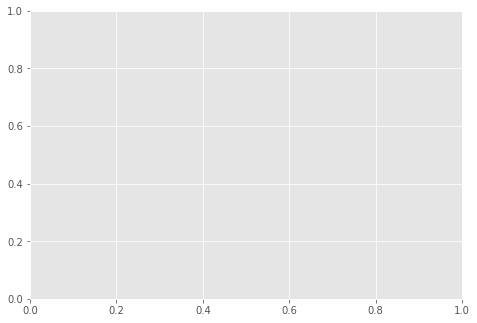

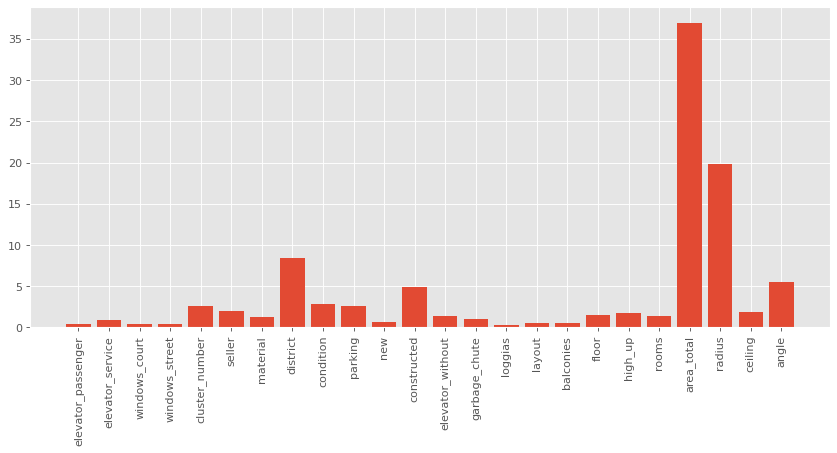

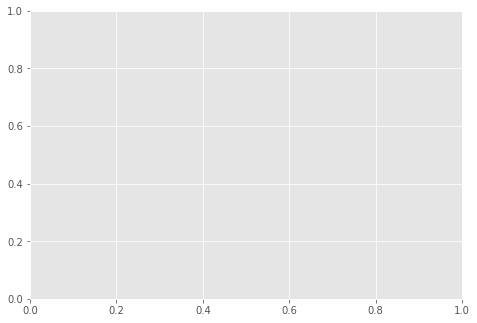

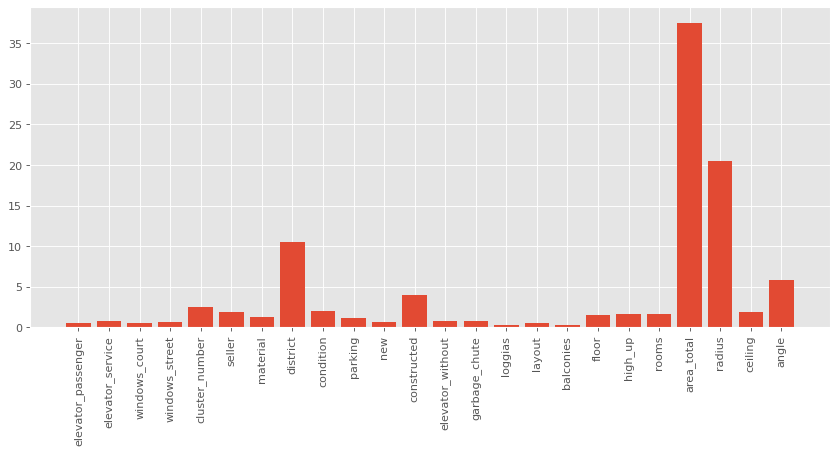

[I 2021-11-18 16:14:51,126] Trial 0 finished with value: 0.16973026099409474 and parameters: {'num_tress': 2484, 'learning_rate': 0.27474035078144743, 'depth': 10, 'l2_leaf_reg': 4, 'random_strength': 0.9313796070818816}. Best is trial 0 with value: 0.16973026099409474.


In [54]:
def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all()
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

### HYPERPARAMETER TUNING
def optimize(trial, x, y, model_to_optimize):
    if (model_to_optimize == 'random_forest'):
        #criterion = trial.suggest_categorical("criterion", ["poisson", "entropy"])
        n_estimators = trial.suggest_int("n_estimators", 50,300)
        max_depth = trial.suggest_int("max_depth",3,100)
        min_samples_leaf = trial.suggest_int("min_samples_leaf",1,10)
        max_features = trial.suggest_uniform("max_features", 0.01,1.0)
        model = RandomForestRegressor(
            n_estimators = n_estimators,
            max_depth = max_depth,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features
        ) 
    elif(model_to_optimize == 'lgbm'):
        num_leaves = trial.suggest_int("num_leaves", 2**3,2**6)
        max_depth = trial.suggest_int("max_depth", 5,20)
        metric = trial.suggest_categorical("metric", ["rmsle"])
        num_iterations = trial.suggest_int("num_iterations", 1000,5000)
        learning_rate = trial.suggest_float("learning_rate", 0.06,0.095)
        bagging_freq = trial.suggest_int("bagging_freq",3,15)
        bagging_fraction = trial.suggest_float("bagging_fraction", 0.6,0.9)
        model = lgb.LGBMRegressor(
            categorical_feature=light_features,
            num_leaves=num_leaves,
            max_depth=max_depth,
            metric=metric,
            num_iterations=num_iterations,
            learning_rate=learning_rate,
            bagging_freq = bagging_freq,
            bagging_fraction = bagging_fraction
        )
    elif(model_to_optimize == 'xgboost'):
        n_estimators = trial.suggest_int("n_estimators", 1000, 6000)
        max_depth = trial.suggest_int("max_depth", 1,10)
        eta = trial.suggest_float("eta", 0.01,0.3)
        subsample = trial.suggest_float("subsample", 0.5,1.0)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.06,1.0)
        model = xgb.XGBRegressor(
            n_estimators = n_estimators,
            max_depth = max_depth,
            eta = eta,
            subsample = subsample,
            colsample_bytree = colsample_bytree,
            random_state = 42

        )
    elif(model_to_optimize == 'gradient_boosting'):
        n_estimators = trial.suggest_int("n_estimators", 500, 800) #729
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1,3) #1
        min_samples_split = trial.suggest_int("min_samples_split", 2,4) #3
        max_depth = trial.suggest_int("max_depth", 5,8) #6
        learning_rate = trial.suggest_float("learning_rate", 0.05,0.25) #0.1582
        model = GradientBoostingRegressor(
            n_estimators = n_estimators,
            max_depth = max_depth,
            min_samples_leaf = min_samples_leaf,
            min_samples_split = min_samples_split,
            learning_rate = learning_rate
        )
    elif(model_to_optimize == 'catboost'): #{'num_tress': 2462, 'learning_rate': 0.4612841758658228, 'depth': 9, 'l2_leaf_reg': 30, 'random_strength': 0.9221431240227759}. Best is trial 1 with value: 0.14328111429180268.
        num_trees=trial.suggest_int("num_tress", 2000,2500)
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.5)
        depth = trial.suggest_int("depth", 6, 10)
        l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 2,30)
        random_strength = trial.suggest_float("random_strength", 0, 1)
        #iterations = trial.suggest_int("iterations", 800, 2500)

        model = CatBoostRegressor( #{'num_tress': 2480, 'learning_rate': 0.14845300119574675, 'depth': 10, 'l2_leaf_reg': 6, 'random_strength': 0.7076806775832747}
            #num_trees=num_trees,
            #learning_rate=learning_rate,
            #depth = depth,
            #l2_leaf_reg = l2_leaf_reg,
            #random_strength = random_strength,
            #iterations = iterations,
            verbose=False,
            loss_function='RMSE',
            random_state=42,
            depth=9,
            learning_rate=0.09,
            iterations=2500

        )

    """  
    n_estimators: The number of trees in the ensemble, often increased until no further improvements are seen.
    max_depth: The maximum depth of each tree, often values are between 1 and 10.
    eta: The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller.
    subsample: The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.
    colsample_bytree: Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features
    """

    kf = KFold(n_splits=2)
    accuracies = []
    count = 0
    for idx in kf.split(X=x,y=y):
        count += 1
        '''print(x.shape)
        print(y.shape)
        print("count: ", count)'''
        train_idx,test_idx = idx[0],idx[1]
        xtrain = x.iloc[train_idx]
        ytrain = y.iloc[train_idx]
        ytrain = np.log(ytrain)/np.log(15)

        #     x_train, x_test = x.iloc[list(train_index)], x.iloc[list(test_index)]

        xtest = x.iloc[test_idx]
        ytest = y.iloc[test_idx]

        model.fit(xtrain,ytrain)
        preds = model.predict(xtest)

        features = model.feature_names_
        importances = model.feature_importances_ 
        fig = plt.figure(figsize=(10, 4), dpi=80)
        ax = fig.add_axes([0,0,1,1])
        ax.bar(features, importances)
        plt.xticks(rotation=90)
        plt.show()
        preds = 15**preds
        fold_acc = root_mean_squared_log_error(ytest,preds)
        accuracies.append(fold_acc)
    return np.mean(accuracies)
#X = data_train_focus_light # for lightGBM
#X = data # for XGboost
X = data_train_focus_cat
optimization_function = partial(optimize,x=X,y = Y, model_to_optimize = 'catboost')
study = optuna.create_study(direction = "minimize")
study.optimize(optimization_function, n_trials = 1)


In [55]:
def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all()
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

#data.info()
#print(len(Y))
#print(data.corr())
kaggle = False
if(kaggle):
    Y = np.log(Y)/np.log(15)

    rf_model = RandomForestRegressor(random_state = 42)
    rf_model.fit(data_rf,Y)
    result_rf = rf_model.predict(data_test_rf)
    print(" rf")
    
    XGB_model = xgb.XGBRegressor(
        n_estimators = 2739,
        max_depth = 9,
        eta = 0.03878,
        subsample=0.787,
        colsample_bytree = 0.925, 
        random_state=42)
    XGB_model.fit(data,Y)
    result_XGB = XGB_model.predict(data_test)
    print('1 of 4 done')
    """
     Trial 24 finished with value: 0.13059627370632038 and parameters: 
     {'n_estimators': 2739, 'max_depth': 9, 'eta': 0.03877885573075956, 'subsample': 0.786976666552837, 
     'colsample_bytree': 0.9250882059087506}.
    """
    #XGB_model = xgb.XGBRegressor(n_estimators = 5000,subsample=0.6,random_state=42)
    #XGB_model.fit(data,Y)
    #result_XGB_2 = XGB_model.predict(data_test)
    print('2 of 4 done')

    lightGBM_model = lgb.LGBMRegressor(
    categorical_feature=light_features,
    num_leaves=32,
    max_depth=14,
    random_state=42,
    metric='rmsle',
    num_iterations=3862,
    learning_rate=0.06,
    bagging_freq = 6,
    bagging_fraction = 0.887)

    """
    'num_leaves': 32, 
'max_depth': 14, 'metric': 'rmsle',
 'num_iterations': 3862, 'learning_rate': 0.06005149369997649,
 'bagging_freq': 6, 'bagging_fraction': 0.8869897798628879
    """

    lightGBM_model.fit(data_train_focus_light,Y,categorical_feature=light_features)
    result_light = lightGBM_model.predict(data_test_focus_light)
    print('3 of 4 done')

    lightGBM_model = lgb.LGBMRegressor(
    categorical_feature=light_features,
    num_leaves=7**2,
    max_depth=7,
    random_state=50,
    metric='rmsle',
    num_iterations=4000,
    learning_rate=0.08,
    bagging_freq = 10,
    bagging_fraction = 0.6)

    #lightGBM_model.fit(data_train_focus_light,Y,categorical_feature=light_features)
    #result_light_2 = lightGBM_model.predict(data_test_focus_light)

    #prediction_kaggle = (0.1*result_light + 0.3*result_XGB + 0.2*result_light_2 + 0.3*result_XGB_2 + 0.1 *result_rf)

    prediction_kaggle = (0.3*result_light + 0.7 *result_XGB)

    print('done')

else:

    y_train = np.log(y_train)/np.log(15)
    XGB_model = xgb.XGBRegressor(n_estimators = 100,subsample=0.9,random_state=42, max_depth = 8)
    XGB_model.fit(X_train,y_train)
    prediction_1 = XGB_model.predict(X_test)

    XGB_model = xgb.XGBRegressor(n_estimators = 200,eta=0.1, subsample=0.8,random_state=42, max_depth =5)
    XGB_model.fit(X_train,y_train)
    prediction_2 = XGB_model.predict(X_test)

    y_train_light = np.log(y_train_light)/np.log(15)
    lightGBM_model = lgb.LGBMRegressor(
    categorical_feature=light_features,
    num_leaves=9**2,
    max_depth=9,
    random_state=42,
    metric='rmsle',
    num_iterations=100,
    learning_rate=0.09,
    bagging_freq = 5,
    bagging_fraction = 0.8)

    lightGBM_model.fit(X_train_light,y_train_light,categorical_feature=light_features)
    result_light = lightGBM_model.predict(X_test_light)

    lightGBM_model = lgb.LGBMRegressor(
    categorical_feature=light_features,
    num_leaves=7**2,
    max_depth=7,
    random_state=42,
    metric='rmsle',
    num_iterations=200,
    learning_rate=0.07,
    bagging_freq = 10,
    bagging_fraction = 0.7)

    lightGBM_model.fit(X_train_light,y_train_light,categorical_feature=light_features)
    result_light_2 = lightGBM_model.predict(X_test_light)

    y_train_cat_2 = np.log(y_train_cat)/np.log(15)
    cat = CatBoostRegressor(loss_function= 'RMSE',verbose=False,random_state = 42, depth=10, learning_rate=0.1, iterations = 200)
    cat.fit(X_train_cat,y_train_cat_2,cat_features=cat_feature)
    result_cat = cat.predict(X_test_cat)


    prediction = (0.15*result_cat + 0.35*prediction_1 + 0.15*result_light + 0.25*prediction_2  + 0.10*result_light_2)
    predictions = [result_cat,prediction_1,result_light,prediction_2,result_light_2]
    print('done')

#lgb.plot_importance(lightGBM_model)
#print(data.test)

if(kaggle):
    prediction_kaggle = 15**prediction_kaggle
    submission = pd.DataFrame()
    submission['id'] = test_id
    submission['price_prediction'] = prediction_kaggle
    submission.to_csv('submission_XGB_EDA.csv', index= False)
else:
    final_prediction = 15**prediction
    rmsle = root_mean_squared_log_error(y_test,final_prediction)
    print("first run", rmsle)

    for i in predictions:
        rmsle = root_mean_squared_log_error(y_test,15**i)
        print(rmsle)


c:\Users\gunna\tdt4173-task-2\moscow_housing\venv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\gunna\tdt4173-task-2\moscow_housing\venv\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Users\gunna\tdt4173-task-2\moscow_housing\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
c:\Users\gunna\tdt4173-task-2\moscow_housing\venv\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict i

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=17]=6.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.

LIGHTGBM:

Trial 15 finished with value: 0.13607468690854335 and parameters: {'num_leaves': 32, 
'max_depth': 14, 'metric': 'rmsle',
 'num_iterations': 3862, 'learning_rate': 0.06005149369997649,
 'bagging_freq': 6, 'bagging_fraction': 0.8869897798628879}. Best is trial 15 with value: 0.13607468690854335.


Trial 30 finished with value: 0.13584755303965582 and parameters: 
{'num_leaves': 22, 'max_depth': 18, 'metric': 'rmsle', 'num_iterations': 4719, 
'learning_rate': 0.06362286817426105, 'bagging_freq': 10, 'bagging_fraction': 0.8651090714389053}.
 Best is trial 30 with value: 0.13584755303965582.

 XGBOOST: 

 Trial 24 finished with value: 0.13059627370632038 and parameters: {'n_estimators': 2739, 'max_depth': 9, 'eta': 0.03877885573075956, 'subsample': 0.786976666552837, 'colsample_bytree': 0.9250882059087506}. Best is trial 24 with value: 0.13059627370632038.

 Gradient boosting:

 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 6, 'n_estimators': 729, 'learning_rate': 0.15823029511056225 => 0.136 med alle features, 0.139 uten irrelevante features. 